## This draft contains reading of database properly

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import re

from os import walk
from os.path import join

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread, imshow, show

In [3]:
# Read classes from file
labels = np.genfromtxt('../classes.csv', delimiter=',', dtype=str)
# because of space after comma we read redundant empty column
labels = np.array([l[0] for l in labels])

In [4]:
data_path = "../database/"
files = list()
for (dirpath, dirnames, filenames) in walk(data_path):
    files = filenames    

In [5]:
data_images = list()
data_labels = list()
label_from_name = r"([a-zA-z]+)[-_]\d+.pgm"

In [6]:
# here we load all the images and find their label from filename
for f in files:
    match = re.match(label_from_name, f)
    if match:
        label = match.groups()[0]
        if label in labels:
            data_labels.append(label)
            data_images.append(imread(join(data_path, f), as_grey=True))      
    else: 
        # if name does not match our regexp or label is not in the list
        # of classes - not read from database
        continue 

In [7]:
im = data_images[0]

In [8]:
data_labels[0]

'key'

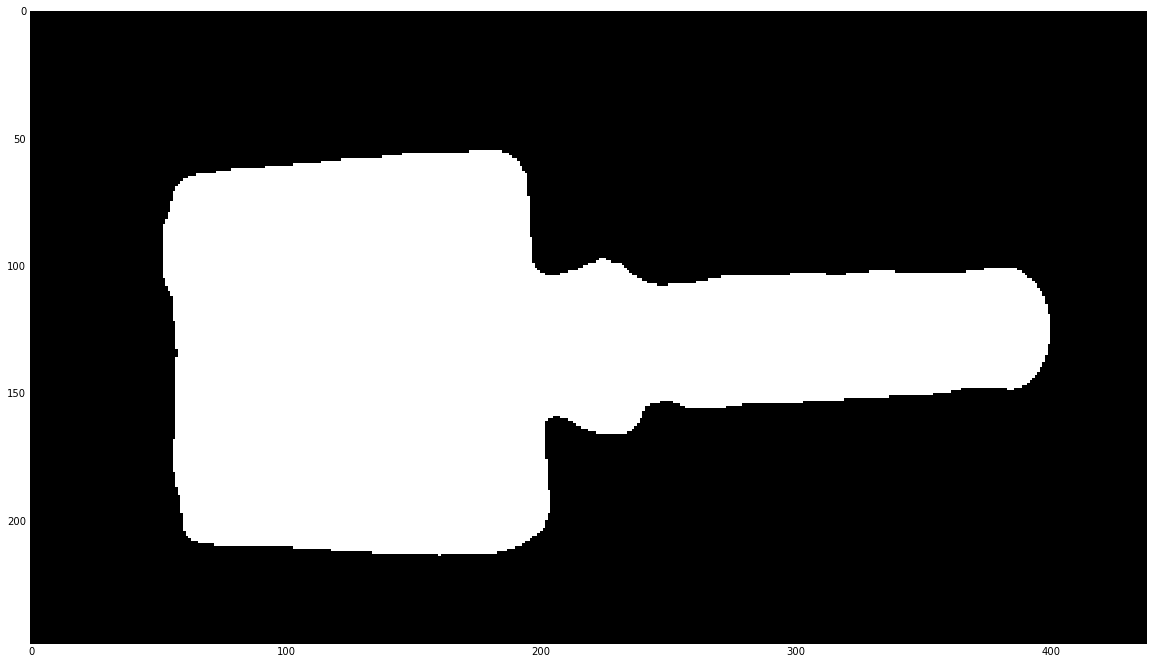

In [9]:
imshow(im)
show()

In [10]:
CONNECTIVITY_INC = {
    4: {
        0: (0, -1),
        1: (-1, 0),
        2: (0, 1),
        3: (1, 0)
    },
    8: {
        0: (0, -1),
        1: (-1, -1),
        2: (-1, 0),
        3: (-1, 1),
        4: (0, 1),
        5: (1, 1),
        6: (1, 0),
        7: (1, -1),
    }
}

In [11]:
def pad_image(im, color="b"):
    if color == "b":
        padded_im = np.array([np.concatenate([[0], row, [0]]) for row in im], dtype=np.uint8)
        new_row = np.zeros((1, padded_im.shape[1]), dtype=np.uint8)
        padded_im = np.concatenate([new_row, padded_im, new_row])
    else:
        raise ValueError("Padding is not implemented for thes color")
    return padded_im

In [12]:
def trace_border(im, connectivity=4):
    border = list()
    # we pad image by one pixel from all sides
    # padding ensures us not to go out of domain
    padded_im = pad_image(im)
    
    background_pixel = padded_im[0][0]
    current_pixel = padded_im[0][0]
    start = None
    
    # find starting pixel
    for i in range(padded_im.shape[0]):
        for j in range(padded_im.shape[1]):
            if padded_im[i][j] != current_pixel:
                start = (i, j)
                border.append((i, j))
                break
        else:
            continue 
            # executed if the loop ended normally (no break)
        break 
        
    # iterations of the algo
    print(start)
    current_pixel = start
    direction = 0
    print("Start iteration of the algorithm... ")
    while (True):
        if connectivity == 8:
            i = (direction + 2) % 8
            while i != (direction + 7) % 8:
                next_pixel = (current_pixel[0] + CONNECTIVITY_INC[connectivity][i][0],
                              current_pixel[1] + CONNECTIVITY_INC[connectivity][i][1])
                if padded_im[next_pixel] != background_pixel:
                    current_pixel = next_pixel
                    border.append(current_pixel)
                    direction = (i + 4) % 8
                    break
                i = (i+1) % 8
        elif connectivity == 4:
            i = (direction + 1) % 4
            while i != (direction + 4) % 8:
                next_pixel = (current_pixel[0] + CONNECTIVITY_INC[connectivity][i][0],
                              current_pixel[1] + CONNECTIVITY_INC[connectivity][i][1])
                if padded_im[next_pixel] != background_pixel:
                    current_pixel = next_pixel
                    border.append(current_pixel)
                    direction = (i + 2) % 4
                    break
                i = (i+1) % 4
        else:
            raise ValueError("Invalid connectivity specified")
    # stop condition 
        if current_pixel == border[0]:
            break
            
    # remove padding from image (it will influence border coordinates)
    border = [(pixel[0] - 1, pixel[1] - 1) for pixel in border]
    
    return border

In [13]:
border = trace_border(im, connectivity=4)

(56, 173)
Start iteration of the algorithm... 


In [14]:
key = data_images[0]

In [15]:
border = trace_border(key, connectivity=4)

(56, 173)
Start iteration of the algorithm... 


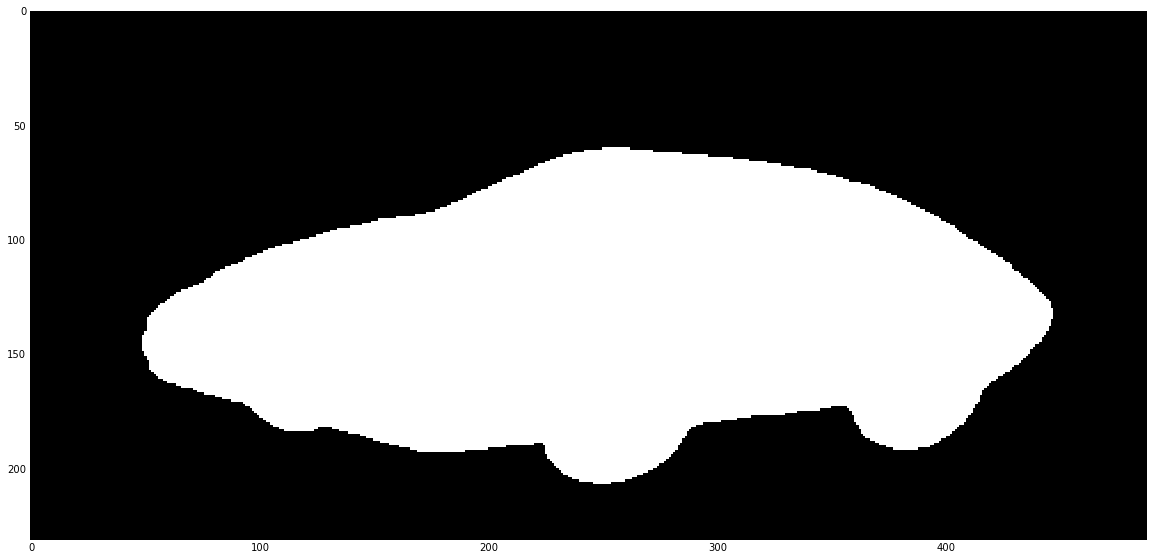

In [16]:
car = data_images[1]
imshow(car)

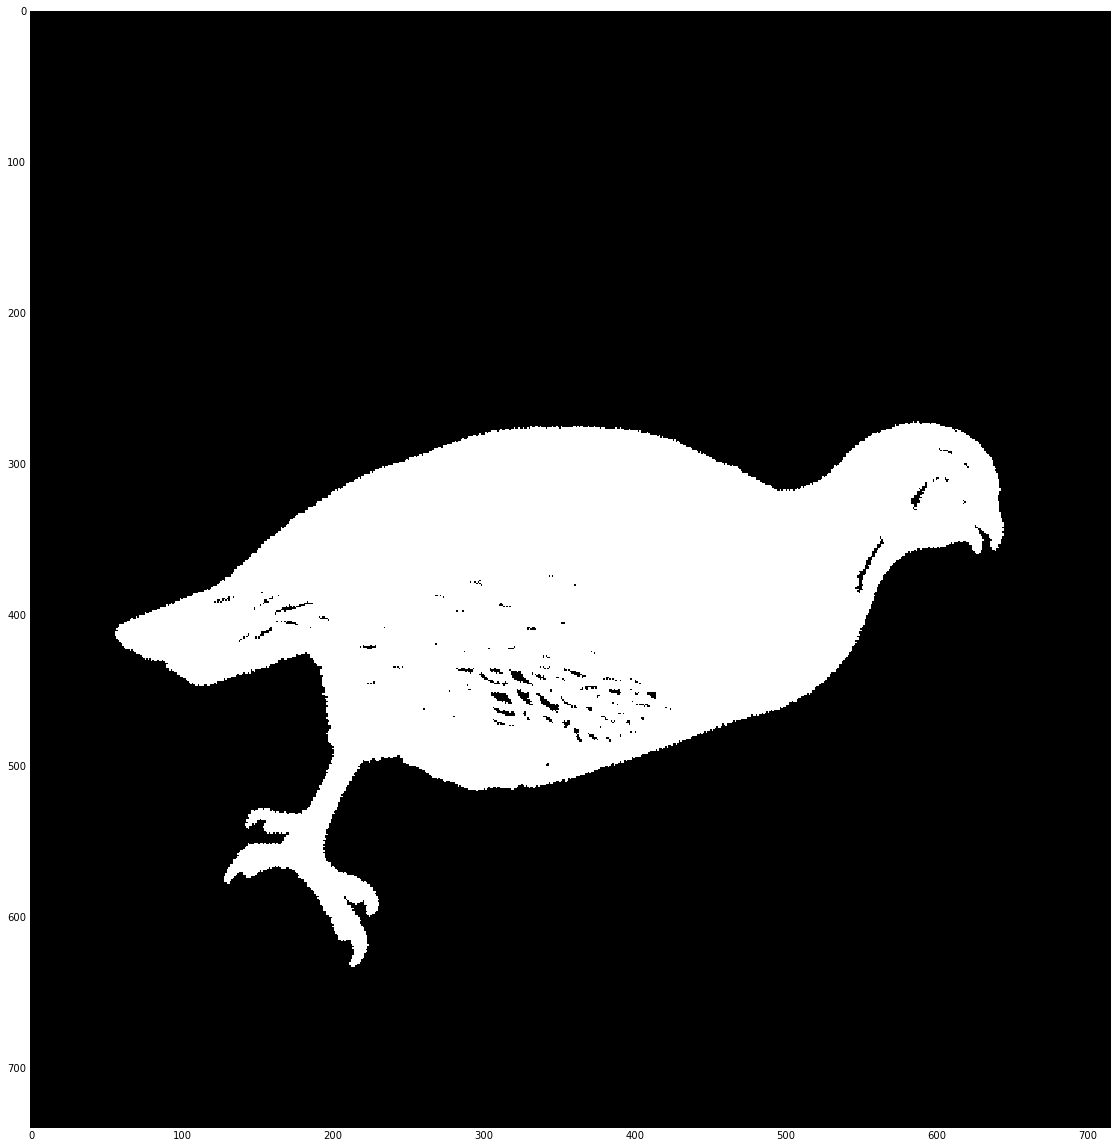

In [17]:
bird = data_images[3]
imshow(bird)

(273, 585)
Start iteration of the algorithm... 
Now find inside points...


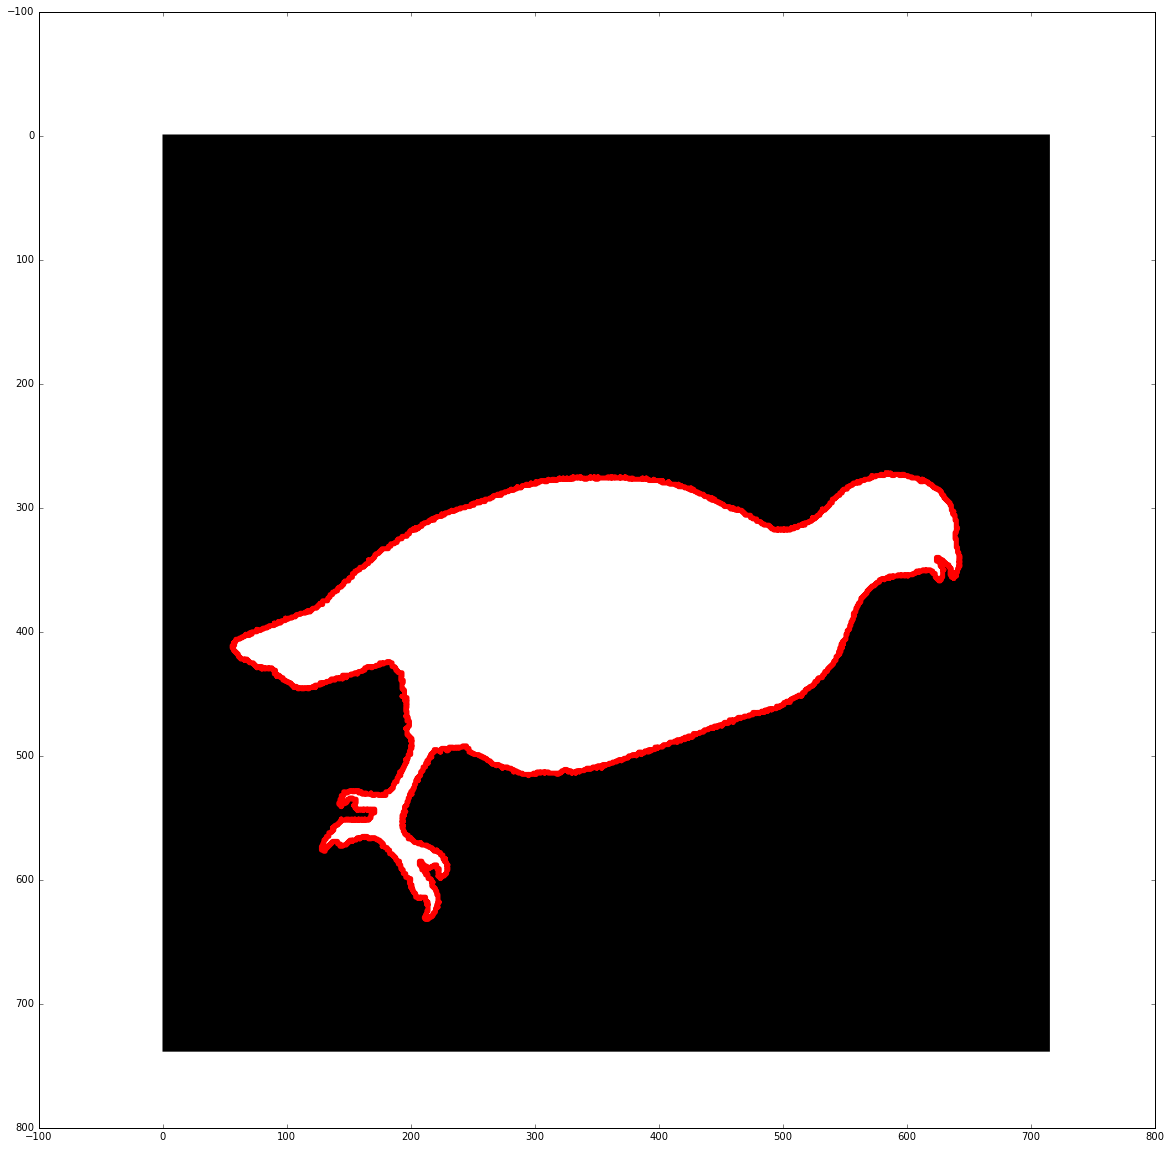

In [18]:
sp = (300,400)

def add_point_inside(im, border, point):
    image = numpy.array(im)
    next_points = [point]
    
    while len(next_points) > 0:
        point = next_points.pop()
        image[point] = 120
        
        top = (point[0]-1, point[1])
        down = (point[0]+1, point[1])
        left = (point[0], point[1]-1)
        right = (point[0], point[1]+1)
        
        if image[top] != 120 and top not in border:
            next_points.append(top)
        if image[down] != 120 and down not in border:
            next_points.append(down)
        if image[left] != 120 and left not in border:
            next_points.append(left)
        if image[right] != 120 and right not in border:
            next_points.append(right)
        
    return image

def make_grey_white(im):
    im[im > 0] = 255
            
border = trace_border(bird, connectivity=4)

print("Now find inside points...")
new_im = bird
new_im = add_point_inside(new_im, border, sp)
make_grey_white(new_im)

width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(new_im, cmap=plt.cm.gray)

ax.plot([b[1] for b in border], [b[0] for b in border], color="r", linewidth=5)

In [19]:
len(border)

3025

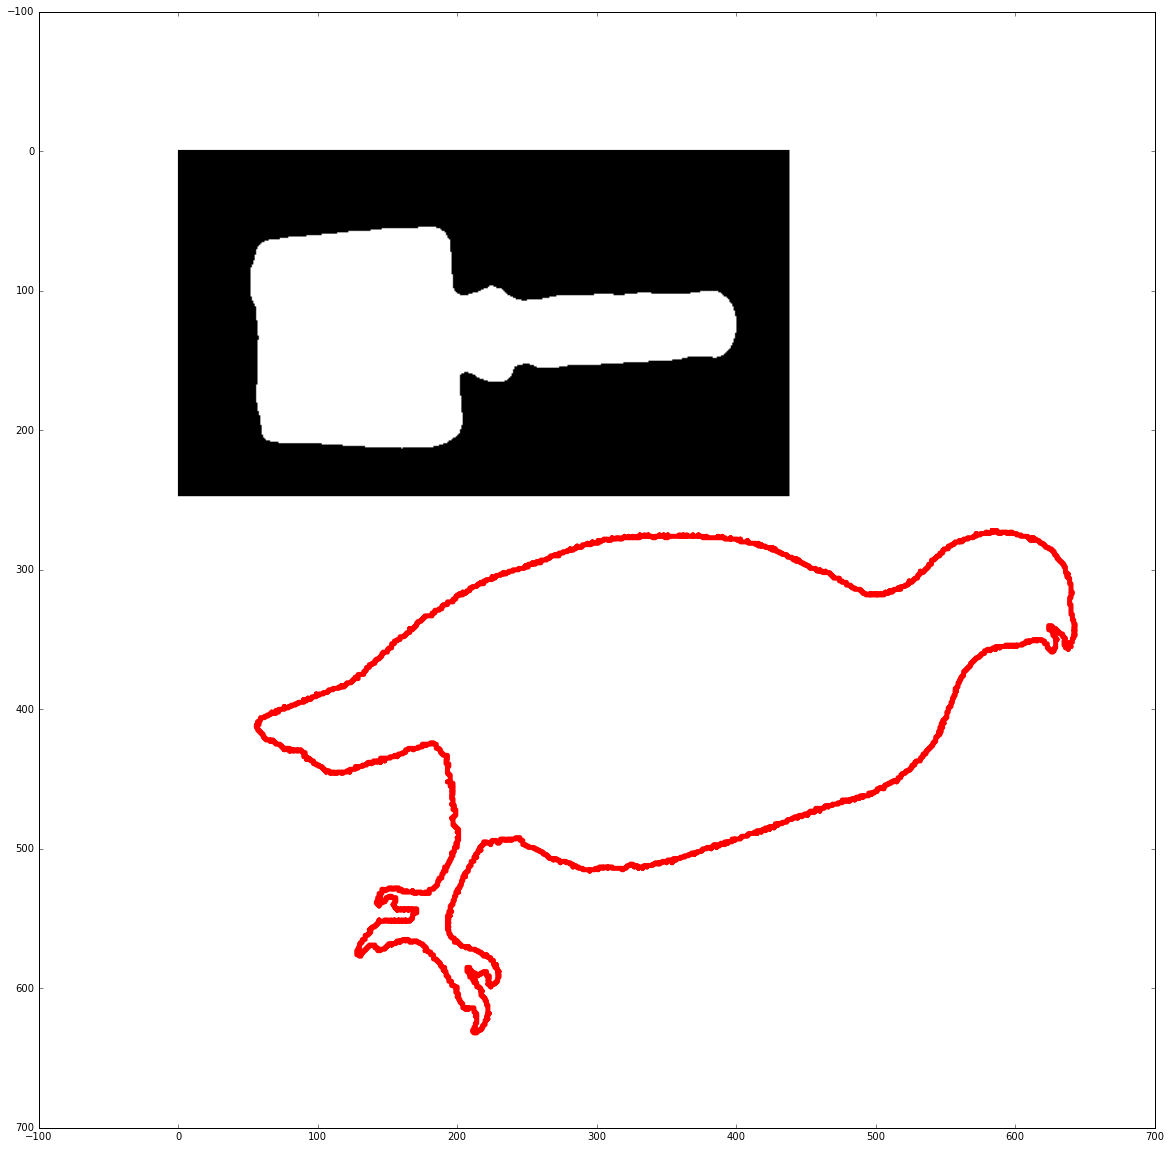

In [20]:
width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(im, cmap=plt.cm.gray)

ax.plot([b[1] for b in border], [b[0] for b in border], color="r", linewidth=5)

In [21]:
vectors = {}
for pixel in border:
    vectors.update({ pixel: []})
    for other_pixel in border:
        if other_pixel != pixel:
            vectors[pixel].append((other_pixel[0] - pixel[0],
                                   other_pixel[1] - pixel[1]))

In [22]:
pixel1_x = [vector[0] for vector in vectors[border[0]]]
pixel1_y = [vector[1] for vector in vectors[border[0]]]

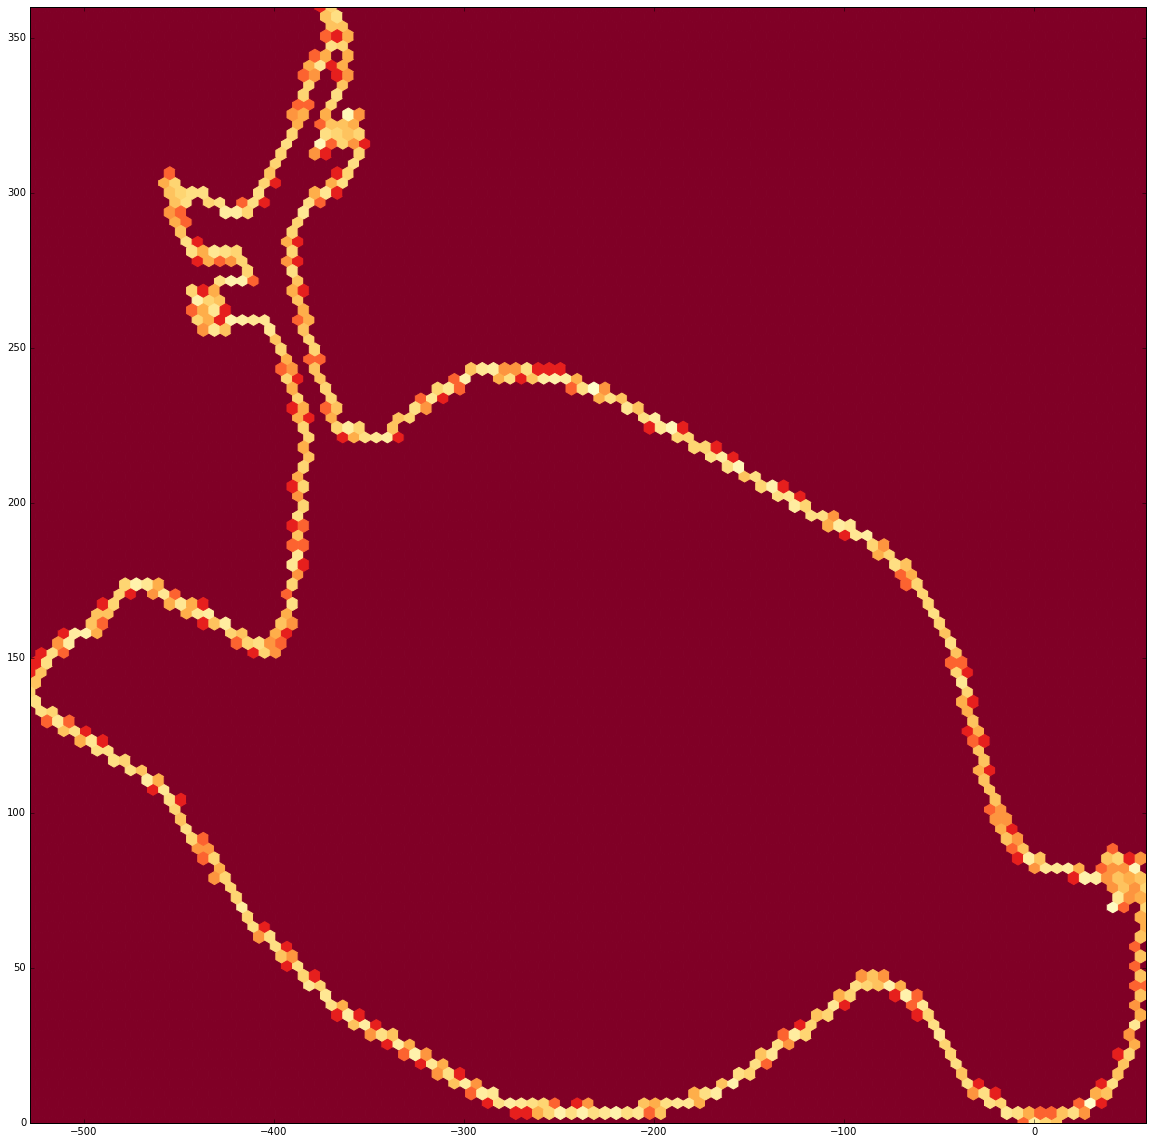

In [23]:
plt.hexbin(pixel1_y, pixel1_x, bins='log', cmap=plt.cm.YlOrRd_r)
plt.figure(figsize=(4,4))
show()

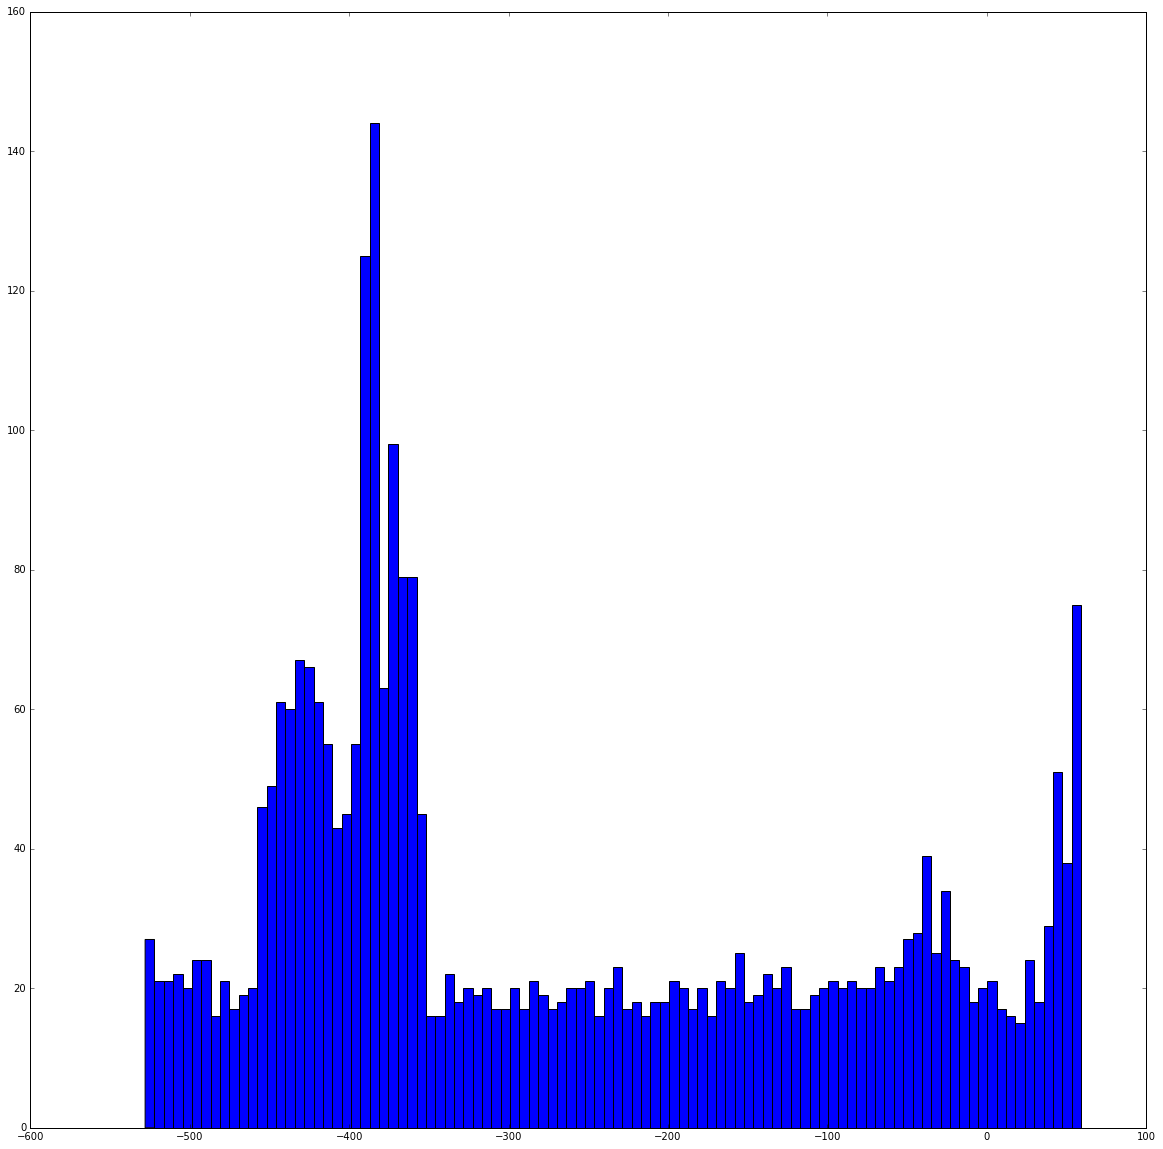

In [24]:
plt.hist(pixel1_y, bins=100)
show()

In [25]:
import skfmm
phi = np.ones((3, 3))
phi[1, 1] = -1
skfmm.distance(phi)

array([[ 1.20710678,  0.5       ,  1.20710678],
       [ 0.5       , -0.35355339,  0.5       ],
       [ 1.20710678,  0.5       ,  1.20710678]])

In [26]:
d = skfmm.distance(im, dx=1e-2)

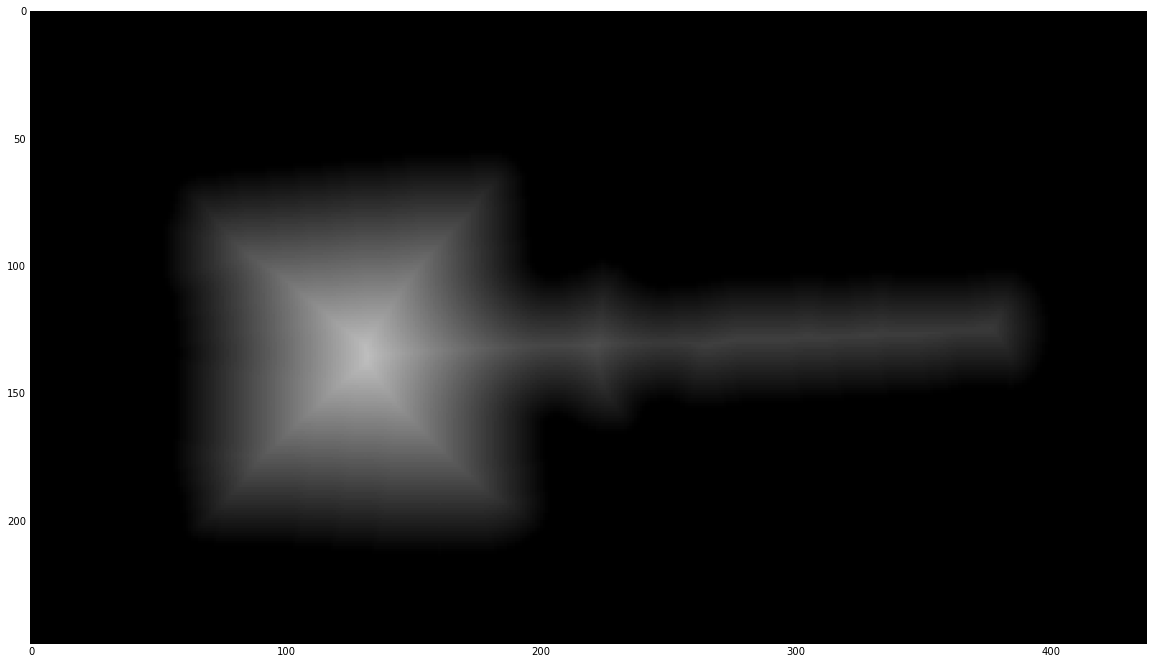

In [27]:
imshow(d, cmap=plt.cm.gray)

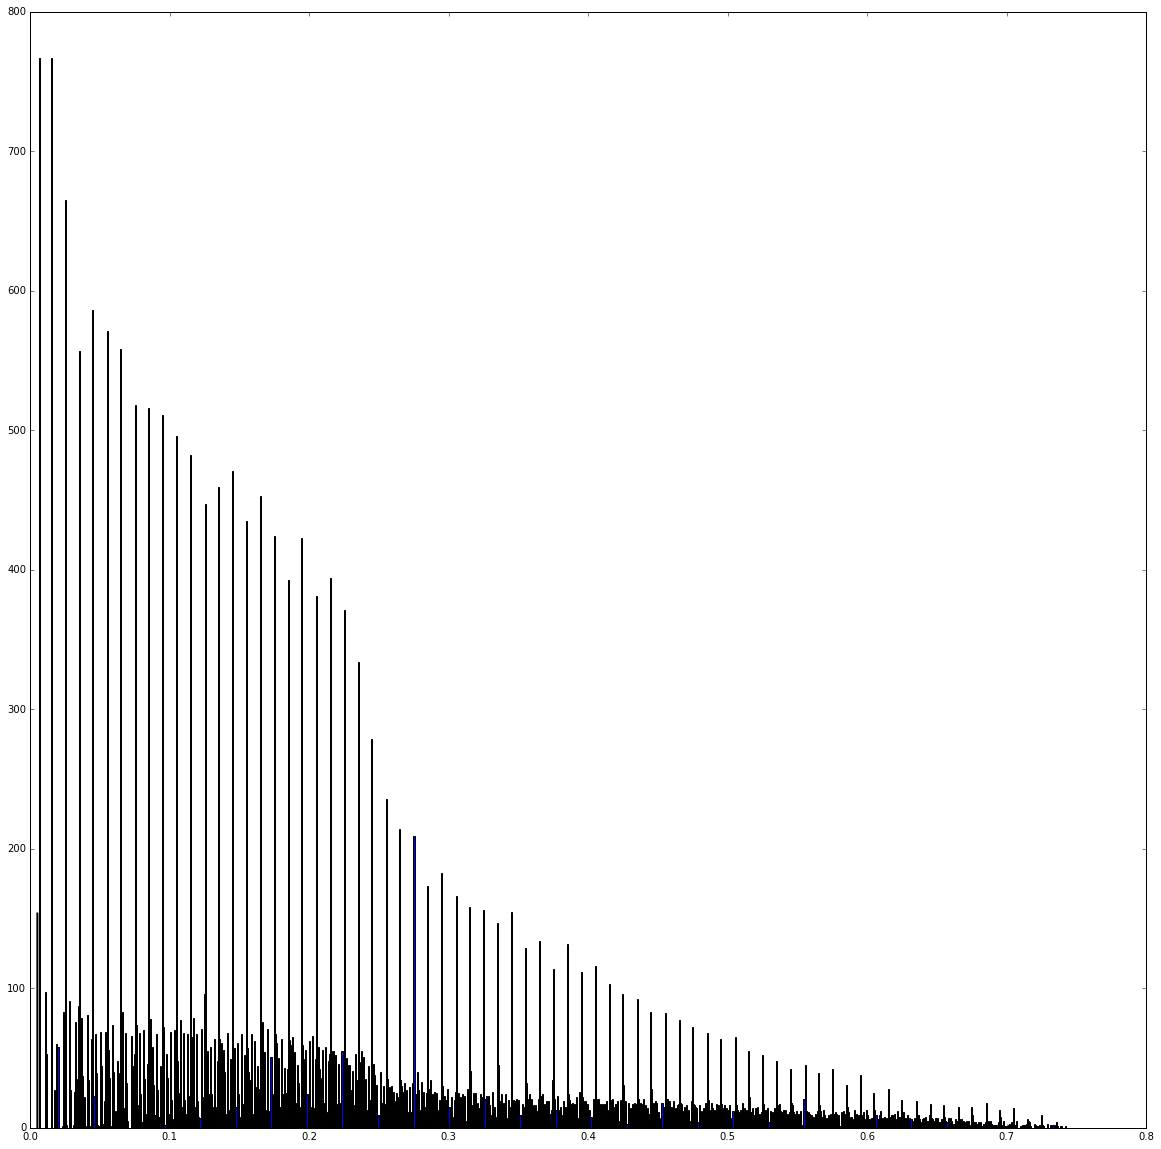

In [28]:
distances = d.flatten()
plt.hist(distances[distances != 0], bins=1000)
show()

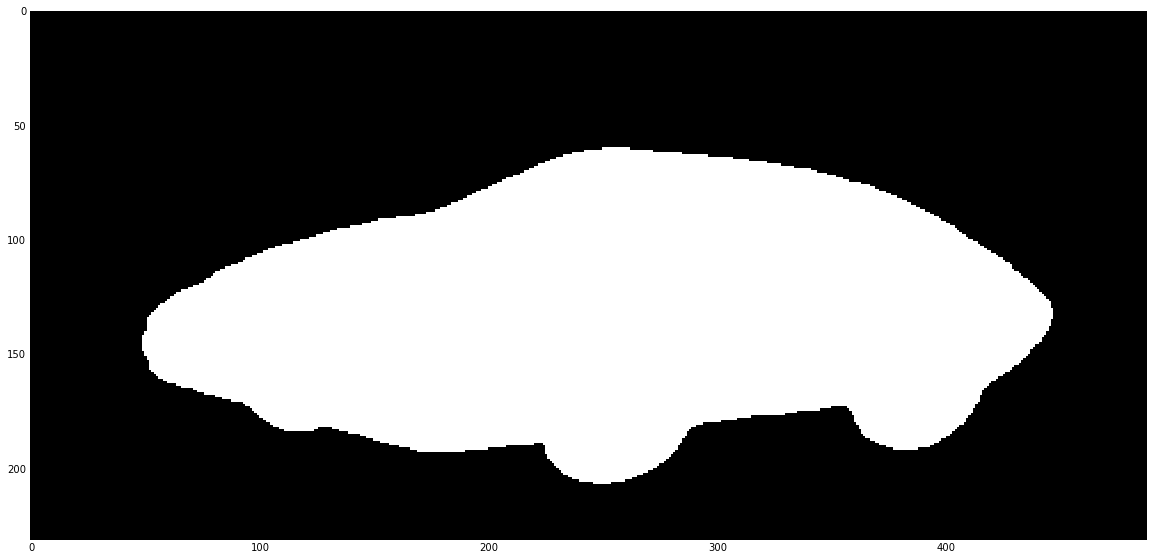

In [29]:
im2 = data_images[1]
imshow(im2, cmap=plt.cm.gray)
show()

In [30]:
im4 = data_images[3]

In [31]:
border2 = trace_border(im4, connectivity=4)

(273, 585)
Start iteration of the algorithm... 


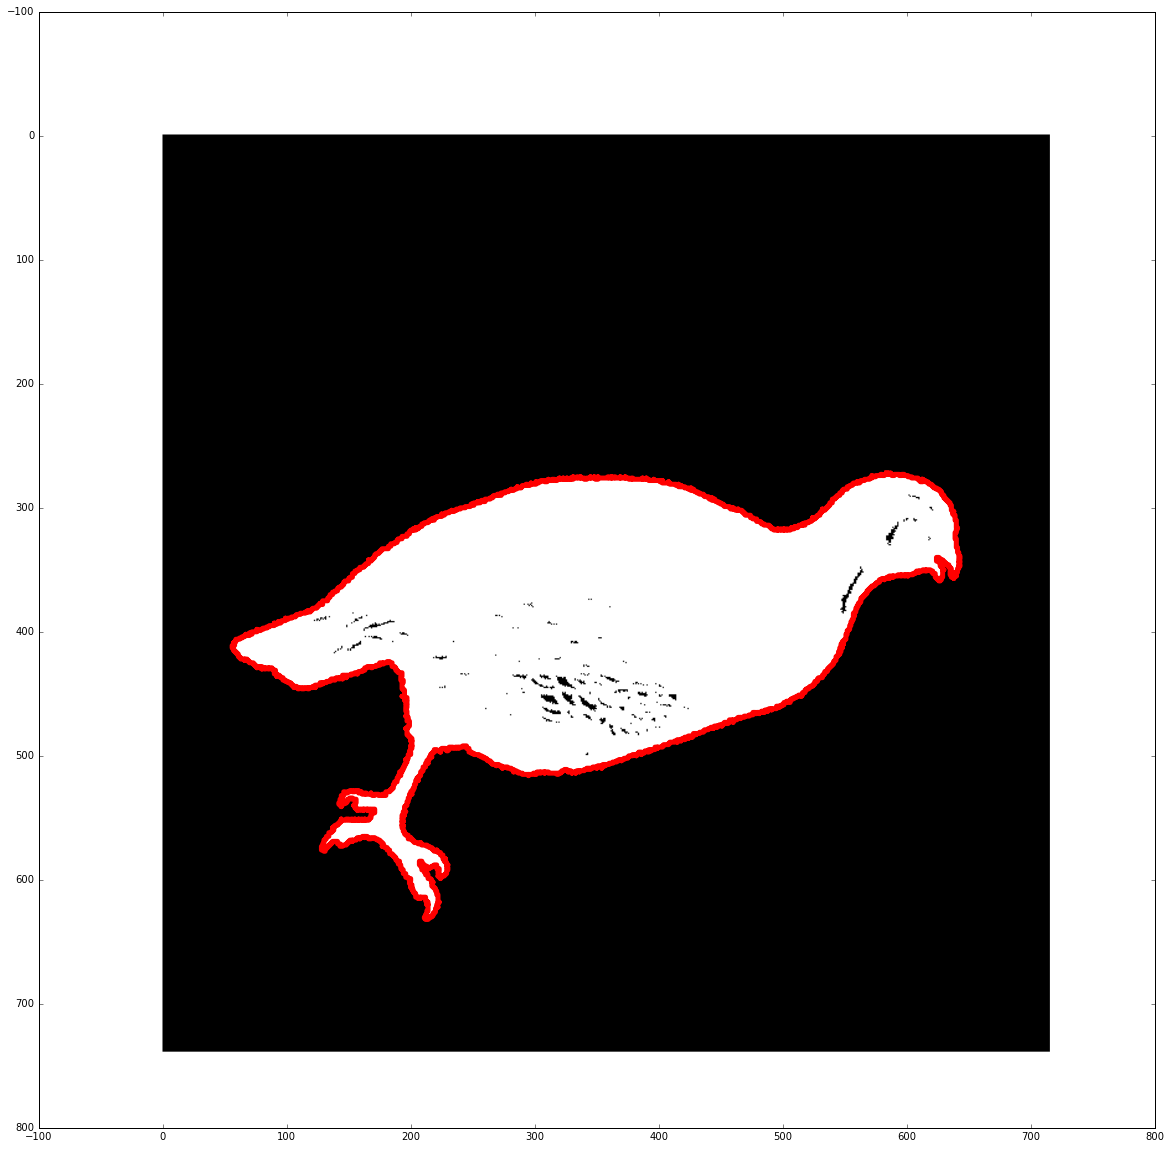

In [32]:
width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(im4, cmap=plt.cm.gray)

ax.plot([b[1] for b in border2], [b[0] for b in border2], color="r", linewidth=5)

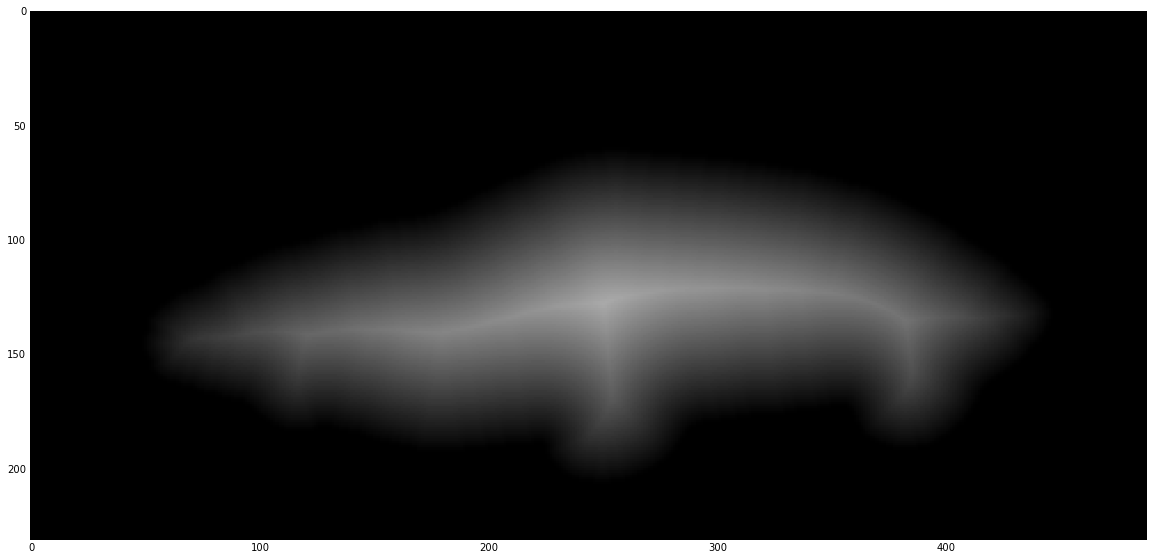

In [33]:
d2 = skfmm.distance(im2, dx=1e-2)
imshow(d2, cmap=plt.cm.gray)
show()

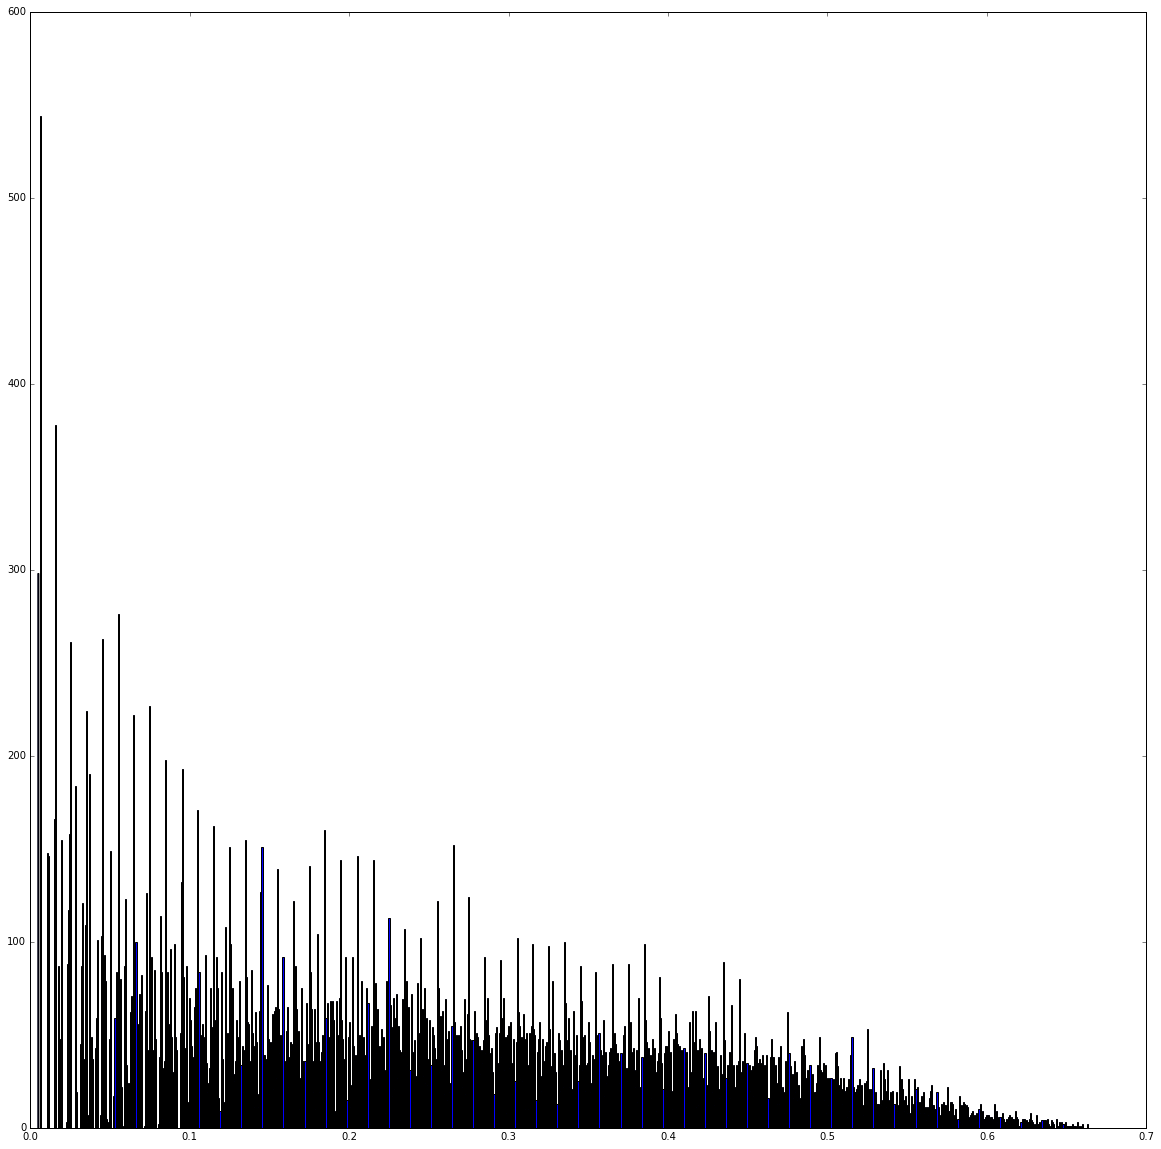

In [34]:
distances2 = d2.flatten()
plt.hist(distances2[distances2 != 0], bins=1000)
show()

In [35]:
?np.histogram

In [36]:
numpy.histogram(distances2, bins=50, weights=distances2)

(array([   8.36096904,   29.35488881,   37.57241745,   48.85135005,
          79.91915361,   81.59887399,   92.12762744,  127.42002975,
         119.29090099,  134.84668428,  168.6576356 ,  160.3697394 ,
         162.22747777,  203.82968354,  197.56848162,  210.47270757,
         232.4614628 ,  226.96328471,  233.23510541,  253.87691066,
         260.92837398,  251.24801031,  274.43818927,  281.96337383,
         281.41736918,  272.76056136,  316.55353181,  280.5506372 ,
         286.54979396,  325.5991656 ,  297.23346164,  288.36847904,
         323.98389113,  290.22207501,  279.90887356,  287.17333014,
         255.70687187,  236.65839693,  252.18886983,  219.05967417,
         181.54156202,  178.83456314,  140.37774306,  115.32372246,
         100.27685517,   76.05474885,   54.2683475 ,   42.82831672,
          28.2929324 ,   12.46329775]),
 array([ 0.        ,  0.0132642 ,  0.0265284 ,  0.03979261,  0.05305681,
         0.06632101,  0.07958521,  0.09284942,  0.10611362,  0.11937782

In [37]:
bin_means = (numpy.histogram(distances2, bins=50)[0] /
             numpy.histogram(distances2, bins=50)[0])

In [38]:
from scipy import interpolate

In [39]:
# sample points from the border
sample_indices = np.sort(numpy.random.choice(range(len(border)), size = 400))
sampled_border = [p for i, p in enumerate(border) if i in sample_indices]

In [40]:
?ax.plot

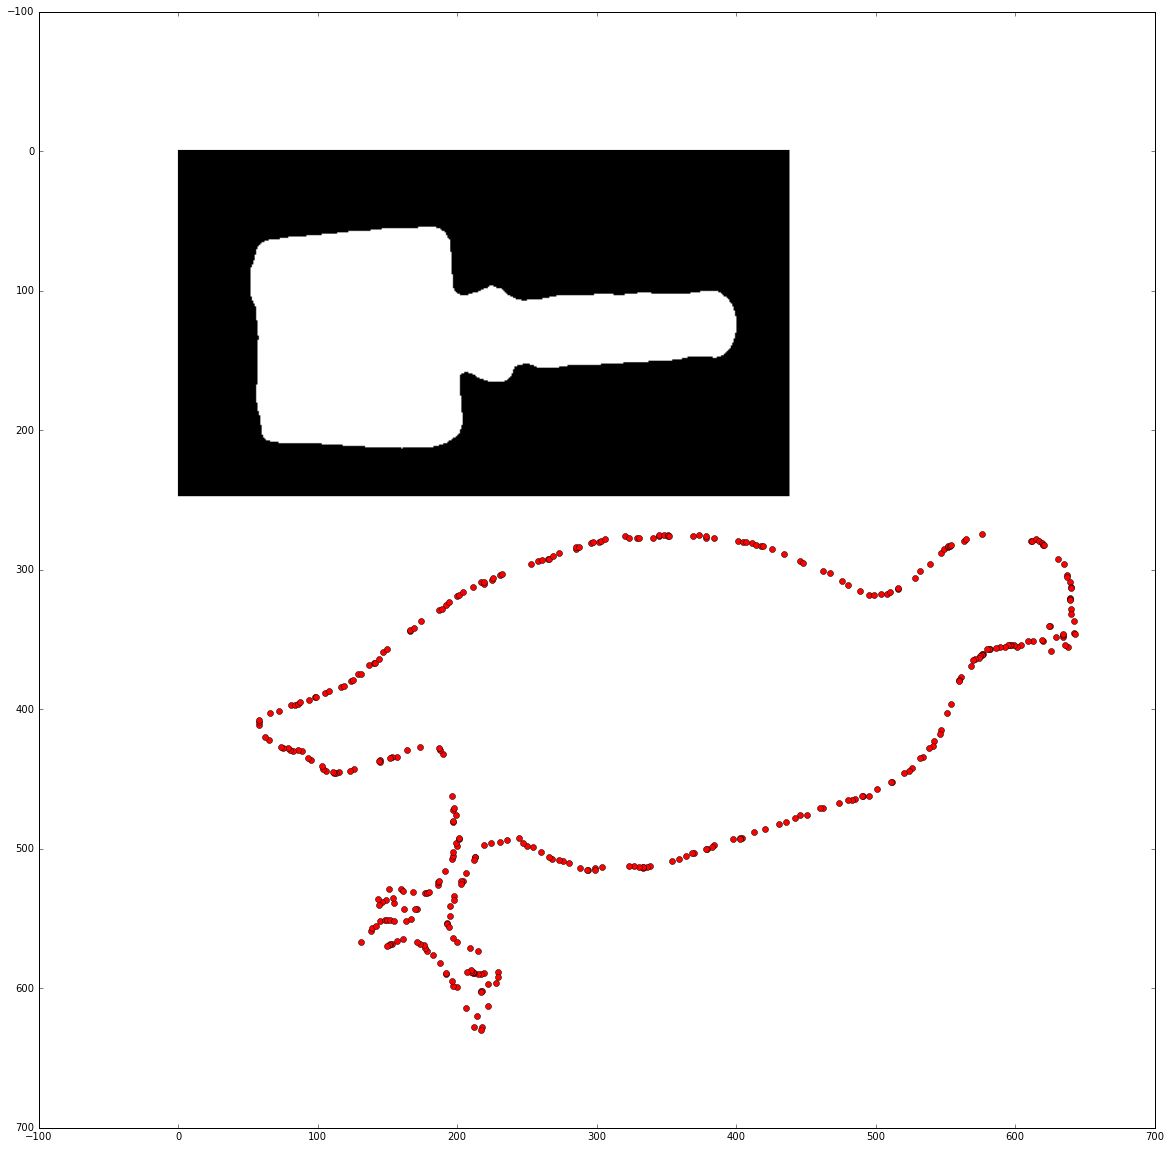

In [41]:
width = 12
height = 12
fig, ax = plt.subplots()
ax.imshow(im, cmap=plt.cm.gray)

ax.plot([b[1] for b in sampled_border], [b[0] for b in sampled_border], "ro", linewidth=1)

In [42]:
w = 5
i = 5
first_ders = []
second_ders = []
while (i != len(border) - 5):
    
    window = [border[i-5],
              border[i-4],
              border[i-3],
              border[i-2],
              border[i-1],
              border[i],
              border[i+1],
              border[i+2],
              border[i+3],
              border[i+4],
              border[i+5]]
    x = [p[1] for p in window]
    y = [p[0] for p in window]
    print(x)
    print(y)
    try:
        tck = interpolate.splrep(x, y, s=3)
        xnew = np.arange(min(x), max(x)+1, step=0.1)
        ynew = interpolate.splev(xnew, tck, der=0)
        first_der = interpolate.splev(border[i][1], tck, der=1)
        second_der = interpolate.splev(border[i][1], tck, der=2)

        if not np.isnan(first_der):
            first_ders.append(first_der)

        if not np.isnan(second_der):
            second_ders.append(second_der)

        print("First der: %f" % first_der)
        print("Second der: %f" % second_der)
    except ValueError:
        pass
        
    
#     plt.figure()
#     plt.plot(x, y, 'x', xnew, ynew)
#     plt.legend(['Linear', 'Cubic Spline'])
#     plt.title('Cubic-spline interpolation')
# #     plt.ylim()
#     plt.show()

    
    i += 1

[584, 584, 585, 586, 587, 587, 587, 588, 588, 589, 590]
[272, 273, 273, 273, 273, 272, 273, 273, 274, 274, 274]
First der: 0.285289
Second der: 0.090020
[584, 585, 586, 587, 587, 587, 588, 588, 589, 590, 590]
[273, 273, 273, 273, 272, 273, 273, 274, 274, 274, 273]
First der: 0.377499
Second der: 0.092481
[585, 586, 587, 587, 587, 588, 588, 589, 590, 590, 591]
[273, 273, 273, 272, 273, 273, 274, 274, 274, 273, 273]
First der: 0.484057
Second der: -0.081396
[586, 587, 587, 587, 588, 588, 589, 590, 590, 591, 592]
[273, 273, 272, 273, 273, 274, 274, 274, 273, 273, 273]
First der: 0.298277
Second der: -0.074197
[587, 587, 587, 588, 588, 589, 590, 590, 591, 592, 593]
[273, 272, 273, 273, 274, 274, 274, 273, 273, 273, 273]
First der: -0.072068
Second der: -0.440866
[587, 587, 588, 588, 589, 590, 590, 591, 592, 593, 594]
[272, 273, 273, 274, 274, 274, 273, 273, 273, 273, 273]
First der: -0.291954
Second der: -0.208876
[587, 588, 588, 589, 590, 590, 591, 592, 593, 594, 594]
[273, 273, 274, 274,

/home/johnpaul/anaconda/envs/venv/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:512: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/home/johnpaul/anaconda/envs/venv/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:512: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


First der: 0.419271
Second der: 0.023648
[373, 373, 373, 374, 375, 376, 376, 377, 378, 378, 379]
[276, 275, 276, 276, 276, 276, 277, 277, 277, 276, 276]
First der: 0.305954
Second der: -0.159015
[373, 373, 374, 375, 376, 376, 377, 378, 378, 379, 379]
[275, 276, 276, 276, 276, 277, 277, 277, 276, 276, 277]
First der: 0.227979
Second der: -0.114797
[373, 374, 375, 376, 376, 377, 378, 378, 379, 379, 380]
[276, 276, 276, 276, 277, 277, 277, 276, 276, 277, 277]
First der: 0.083122
Second der: -0.011561
[374, 375, 376, 376, 377, 378, 378, 379, 379, 380, 381]
[276, 276, 276, 277, 277, 277, 276, 276, 277, 277, 277]
First der: 0.018777
Second der: 0.016533
[375, 376, 376, 377, 378, 378, 379, 379, 380, 381, 382]
[276, 276, 277, 277, 277, 276, 276, 277, 277, 277, 277]
First der: 0.013698
Second der: -0.044560
[376, 376, 377, 378, 378, 379, 379, 380, 381, 382, 383]
[276, 277, 277, 277, 276, 276, 277, 277, 277, 277, 277]
First der: 0.114407
Second der: 0.026894
[376, 377, 378, 378, 379, 379, 380, 3

In [43]:
from scipy import ndimage as ndi
from skimage.morphology import medial_axis


In [44]:
skel, distance = medial_axis(im, return_distance=True)
dist_on_skel = distance * skel

In [45]:
distance[50]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [46]:
?np.histogram

In [47]:
l = [ 0.00247444,  0.00329925,  0.00357419,  0.05663721,  0.01374689,
         0.01237221,  0.01127245,  0.01072258,  0.01072258,  0.01154739]

In [48]:
distance.shape

(248, 438)

In [49]:
dist_on_skel[dist_on_skel != 0.0].shape

(496,)

In [50]:
bins = np.histogram(dist_on_skel[dist_on_skel != 0.0], bins=50)[0]

In [51]:
bins / sum(bins)

array([ 0.00604839,  0.00201613,  0.00403226,  0.00201613,  0.00403226,
        0.00201613,  0.00604839,  0.00403226,  0.00806452,  0.00403226,
        0.00604839,  0.00403226,  0.00806452,  0.00403226,  0.00403226,
        0.16129032,  0.14314516,  0.02016129,  0.05443548,  0.03629032,
        0.02620968,  0.02016129,  0.0141129 ,  0.02419355,  0.01612903,
        0.02620968,  0.01612903,  0.02016129,  0.01209677,  0.01612903,
        0.02016129,  0.01008065,  0.02016129,  0.0141129 ,  0.01814516,
        0.01612903,  0.01612903,  0.0141129 ,  0.02016129,  0.01209677,
        0.01814516,  0.0141129 ,  0.01814516,  0.0141129 ,  0.0141129 ,
        0.01814516,  0.01209677,  0.02016129,  0.0141129 ,  0.02016129])

In [52]:
sum(bins)

496

(array([  1.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   2.,   0.,   2.,
          0.,   0.,   2.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,   1.,
          0.,   1.,   1.,   0.,   0.,   2.,   0.,   2.,   0.,   0.,   2.,
          0.,   0.,   2.,   0.,   0.,  36.,   3.,  33.,   8.,  11.,  55.,
          4.,   1.,   4.,   1.,   4.,   1.,   1.,  14.,   7.,   5.,   7.,
          3.,   1.,   7.,   4.,   6.,   1.,   2.,   3.,   2.,   1.,   4.,
          1.,   1.,   4.,   1.,   5.,   0.,   1.,   6.,   0.,   2.,   5.,
          1.,   6.,   0.,   1.,   6.,   0.,   2.,   4.,   2.,   0.,   5.,
          0.,   5.,   0.,   2.,   3.,   1.,   2.,   3.,   2.,   1.,   2.,
          3.,   2.,   3.,   0.,   3.,   2.,   0.,   5.,   0.,   3.,   2.,
          1.,   4.,   1.,   1.,   4.,   0.,   2.,   3.,   2.,   3.,   1.,
          2.,   2.,   2.,   1.,   3., 

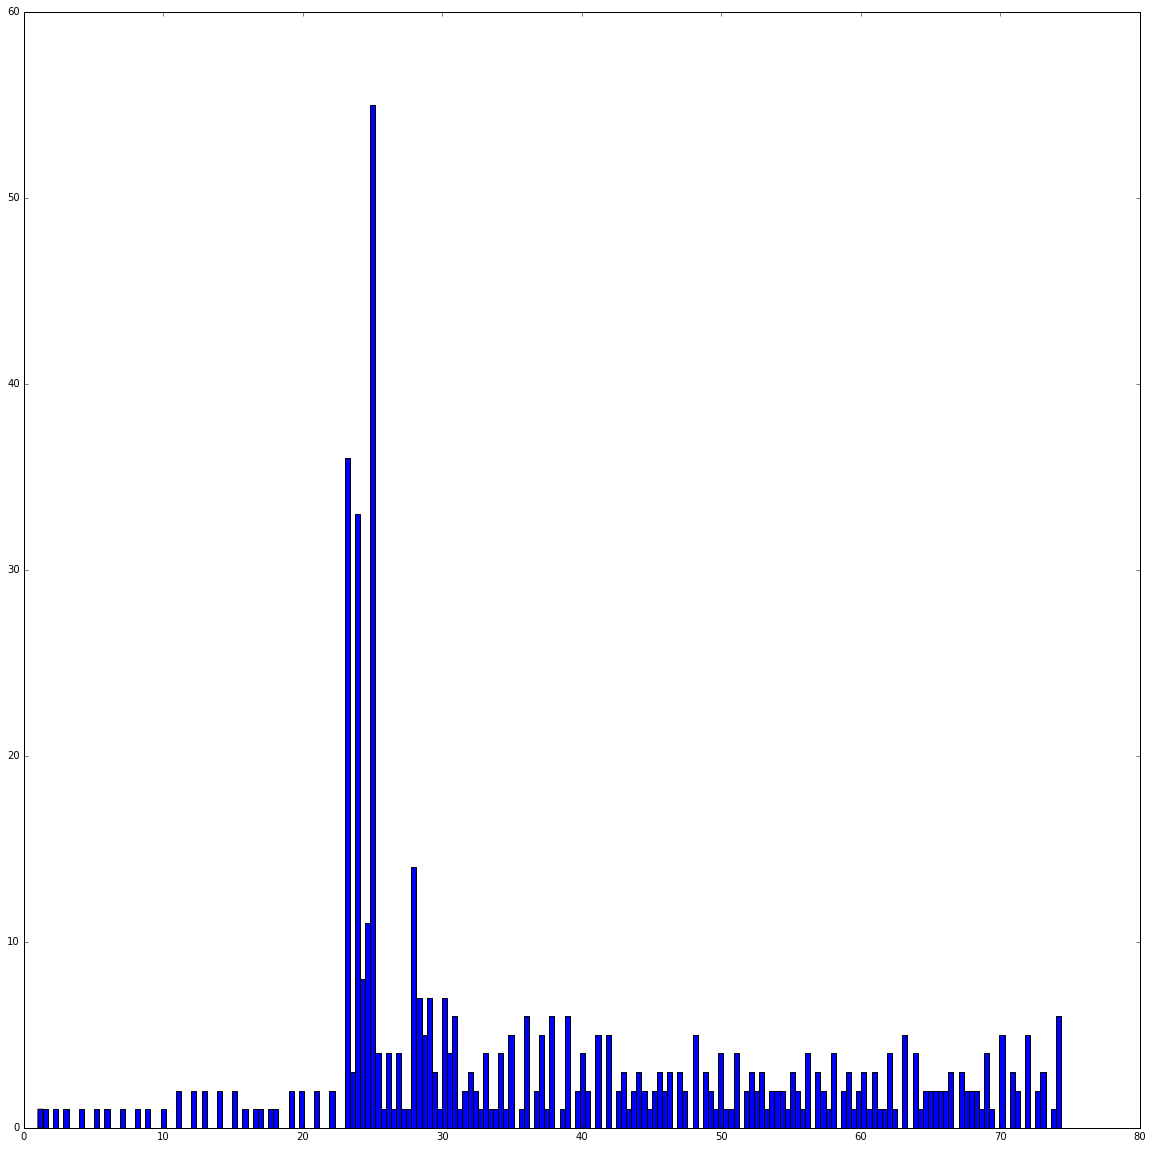

In [53]:
hist(dist_on_skel[dist_on_skel != 0.0], bins=200)


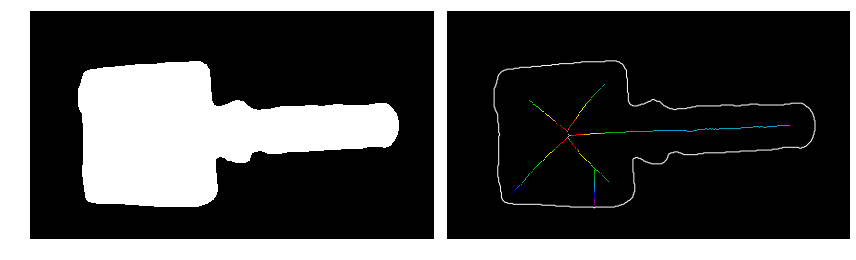

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True,
                               subplot_kw={'adjustable': 'box-forced'})
ax1.imshow(im, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap=plt.cm.spectral, interpolation='nearest')
ax2.contour(im, [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()


In [55]:
skel, distance = medial_axis(im2, return_distance=True)
dist_on_skel = distance * skel

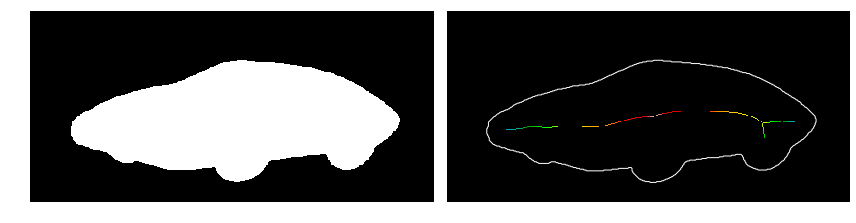

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True,
                               subplot_kw={'adjustable': 'box-forced'})
ax1.imshow(im2, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap=plt.cm.spectral, interpolation='nearest')
ax2.contour(im2, [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()


In [57]:
im3 = data_images[2]

In [58]:
skel, distance = medial_axis(im3, return_distance=True)
dist_on_skel1 = distance * skel

In [76]:
dist_on_skel1 

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

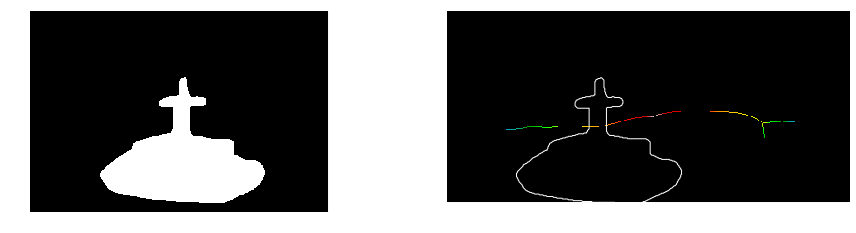

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True,
                               subplot_kw={'adjustable': 'box-forced'})
ax1.imshow(im3, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap=plt.cm.spectral, interpolation='nearest')
ax2.contour(im3, [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()


In [79]:
def medial_axis_skeleton(im):
    """Find skeleton and the distances of points on skeleton to the border."""
    skel, distance = medial_axis(im, return_distance=True)
    dist_on_skel = distance * skel
    return dist_on_skel

In [90]:
def n_skeleton_branches(image):
    skeleton = medial_axis_skeleton(image)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True,
                               subplot_kw={'adjustable': 'box-forced'})
    ax1.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax1.axis('off')
    ax2.imshow(skeleton, cmap=plt.cm.spectral, interpolation='nearest')
    ax2.contour(image, [0.5], colors='w')
    ax2.axis('off')

    fig.tight_layout()
    plt.show()
    peaks = 0
    skeleton[skeleton != 0] = 1
    for i in range(1, skeleton.shape[0] - 1):
        for j in range(1, skeleton.shape[1] - 1):
            skeleton_pixels_in_neighborhood =\
                skeleton[i - 1][j - 1] +\
                skeleton[i - 1][j] +\
                skeleton[i - 1][j + 1] +\
                skeleton[i][j - 1] +\
                skeleton[i][j] +\
                skeleton[i][j + 1] +\
                skeleton[i + 1][j - 1] +\
                skeleton[i + 1][j] +\
                skeleton[i + 1][j + 1]
            if skeleton_pixels_in_neighborhood == 1:
                peaks += 1
    return peaks

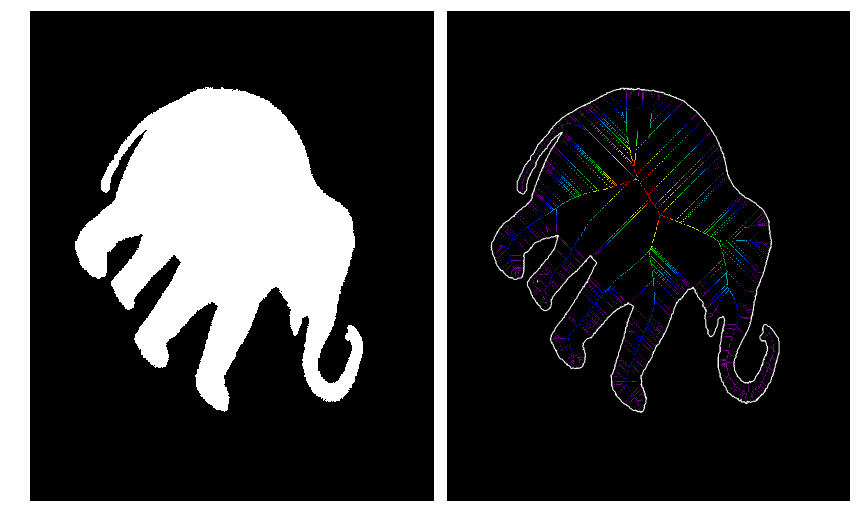

In [95]:
peaks = n_skeleton_branches(data_images[34])

In [96]:
peaks

12269

In [73]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
h, theta, d = hough_line(dist_on_skel1)
lines = probabilistic_hough_line(dist_on_skel1, threshold=10, line_length=5,
                                 line_gap=3)

In [74]:
for line in lines:
    a = np.array(line[0])
    b = np.array(line[1])
    print(numpy.linalg.norm(a-b))

42.0475920833
6.0
39.5979797464
19.1049731745
7.0
7.07106781187
10.0498756211
19.4164878389
7.0
11.1803398875
28.6356421266
15.2970585408
14.1421356237
17.0293863659
14.5602197786
5.0
10.0
6.0
5.09901951359
8.0
18.0
5.0
6.0
12.7279220614
12.1655250606
9.0
6.0
8.48528137424
8.0622577483
14.1421356237
6.0
16.9705627485
5.0


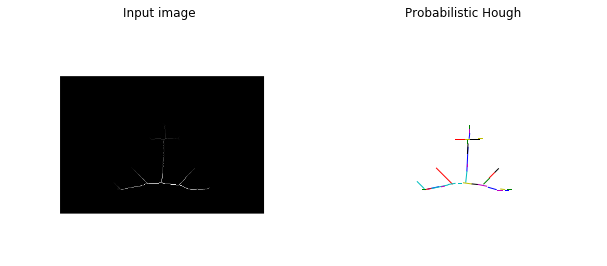

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax1.imshow(dist_on_skel1, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_axis_off()

for line in lines:
    p0, p1 = line
    ax2.plot((p0[0], p1[0]), (p0[1], p1[1]))

ax2.set_title('Probabilistic Hough')
ax2.set_axis_off()
plt.show()

In [63]:
h, theta, d = hough_line(dist_on_skel2)
lines2 = probabilistic_hough_line(dist_on_skel2, threshold=10, line_length=5,
                                 line_gap=3)

for line in lines2:
    a = np.array(line[0])
    b = np.array(line[1])
    print(numpy.linalg.norm(a-b))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

ax1.imshow(dist_on_skel2, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_axis_off()

for line in lines2:
    p0, p1 = line
    ax2.plot((p0[0], p1[0]), (p0[1], p1[1]))

ax2.set_title('Probabilistic Hough')
ax2.set_axis_off()
plt.show()

NameError: name 'dist_on_skel2' is not defined

In [ ]:

skel, distance = medial_axis(new_im, return_distance=True)
dist_on_skel = distance * skel

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True,
                               subplot_kw={'adjustable': 'box-forced'})
ax1.imshow(new_im, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap=plt.cm.spectral, interpolation='nearest')
ax2.contour(new_im, [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()


In [ ]:
from skimage.filters.rank import median
from skimage.morphology import disk

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True,
                               subplot_kw={'adjustable': 'box-forced'})

new_im_nonoise = numpy.array(new_im)
new_im_nonoise = median(new_im_nonoise, disk(5))

skel, distance = medial_axis(new_im_nonoise, return_distance=True)
dist_on_skel = distance * skel

ax1.imshow(new_im_nonoise, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap=plt.cm.spectral, interpolation='nearest')
ax2.contour(new_im_nonoise, [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()


In [ ]:
im5 = data_images[4]
skel, distance = medial_axis(im5, return_distance=True)
dist_on_skel2 = distance * skel

In [ ]:
dist_on_skel2

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True,
                               subplot_kw={'adjustable': 'box-forced'})
ax1.imshow(im5, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap=plt.cm.spectral, interpolation='nearest')
ax2.contour(im5, [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()


In [ ]:
cow = data_images[4]
imshow(cow)

In [ ]:
cow = data_images[4]

# White filling
border = trace_border(cow, connectivity=4)

print("Now find inside points...")
new_im2 = cow
new_im2 = add_point_inside(new_im2, border, (200, 200))
make_grey_white(new_im2)



# NO noise + skel

from skimage.filters.rank import median
from skimage.morphology import disk

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8), sharex=True, sharey=True,
                               subplot_kw={'adjustable': 'box-forced'})

new_im_nonoise = numpy.array(new_im2)
new_im_nonoise = median(new_im_nonoise, disk(5))

skel, distance = medial_axis(new_im_nonoise, return_distance=True)
dist_on_skel = distance * skel

ax1.imshow(new_im_nonoise, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dist_on_skel, cmap=plt.cm.spectral, interpolation='nearest')
ax2.contour(new_im_nonoise, [0.5], colors='w')
ax2.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
np.histogram(dist_on_skel2.flatten()[dist_on_skel.flatten() != 0.], bins=100, density=True)

In [ ]:
np.histogram(dist_on_skel2.flatten()[dist_on_skel.flatten() != 0.], bins=100, density=True)

In [ ]:
plt.hist(dist_on_skel.flatten()[dist_on_skel.flatten() != 0.], bins=1000)
show()

In [ ]:
len(border)

In [ ]:
len(first_ders)

In [ ]:
def indexing(data):
    """This function vectorizes the images with our implemented indexing method."""
#   here we can include contour finding
#   and all other things we do to find img description
#   should return np.appay that is of the same size (?) for all images
#   and each row represents image features
#   so later we can just pass it to the classifier 
    pass

In [ ]:
# Later we would do:

In [ ]:
# X = indexing(data_images)
# y = np.array(data_labels)

In [ ]:
# clf = OneVsRestClassifier(GaussianNB())
# clf.fit(X, y)